In [1]:
pip install scikit-surprise

     |████████████████████████████████| 11.8 MB 3.1 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1630195 sha256=e091aca2bc170f98aa15873ae14308ccbf11e21fada248a1f605a794778ddc93
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [2]:
import pandas as pd 
import numpy as np
import math
import re 
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate


## data loading


In [3]:
cb1_path ='/content/drive/MyDrive/Colab Notebooks/넷플릭스 영화추천/combined_data_1.txt'
cb2_path = '/content/drive/MyDrive/Colab Notebooks/넷플릭스 영화추천/combined_data_2.txt'
cb3_path = '/content/drive/MyDrive/Colab Notebooks/넷플릭스 영화추천/combined_data_3.txt'
cb4_path ='/content/drive/MyDrive/Colab Notebooks/넷플릭스 영화추천/combined_data_4.txt'

In [4]:
# usecols : 사용할 컬럼
df1 =  pd.read_csv(cb1_path, header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
df2 =  pd.read_csv(cb2_path, header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
df3 =  pd.read_csv(cb3_path, header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
df4 =  pd.read_csv(cb4_path, header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])

In [5]:
df1

,Cust_Id,Rating
0,1:,NaN
1,1488844,3.0
2,822109,5.0
3,885013,4.0
4,30878,4.0
...,...,...
24058258,2591364,2.0
24058259,1791000,2.0
24058260,512536,5.0
24058261,988963,3.0


In [6]:
print(df1.dtypes)
print("=======")
print(df2.dtypes)
print("=======")
print(df3.dtypes)
print("=======")
print(df4.dtypes)

Cust_Id     object
Rating     float64
dtype: object
Cust_Id     object
Rating     float64
dtype: object
Cust_Id     object
Rating     float64
dtype: object
Cust_Id     object
Rating     float64
dtype: object


In [7]:
df1['Rating'] = df1['Rating'].astype(float)
df2['Rating'] = df2['Rating'].astype(float)
df3['Rating'] = df3['Rating'].astype(float)
df4['Rating'] = df4['Rating'].astype(float)

In [8]:
print('Dataset 1 shape : {}'.format(df1.shape))
print('-Dataset examples-')
print(df1.iloc[::5000000, :])

Dataset 1 shape : (24058263, 2)
-Dataset examples-
          Cust_Id  Rating
0              1:     NaN
5000000   2560324     4.0
10000000  2271935     2.0
15000000  1921803     2.0
20000000  1933327     3.0


In [9]:
df = df1
df = df1.append(df2)
# df = df.append(df3)
# df = df.append(df4)

In [10]:
df

,Cust_Id,Rating
0,1:,NaN
1,1488844,3.0
2,822109,5.0
3,885013,4.0
4,30878,4.0
...,...,...
26982297,2420260,1.0
26982298,761176,3.0
26982299,459277,3.0
26982300,2407365,4.0


## data viewing

In [11]:
p = df.groupby('Rating')['Rating'].agg(['count'])

In [12]:
p

,count
Rating,
1.0,2376944
2.0,5208010
3.0,14730279
4.0,17149528
5.0,11566594


In [19]:
print(df.isnull().sum())

print(df.isnull().sum()[1])

Cust_Id       0
Rating     9210
dtype: int64
9210


In [20]:
movie_count = df.isnull().sum()[1]

In [21]:
df['Cust_Id'].nunique()

487228

In [22]:
cust_count = df['Cust_Id'].nunique() - movie_count
rating_count = df['Cust_Id'].count() - movie_count

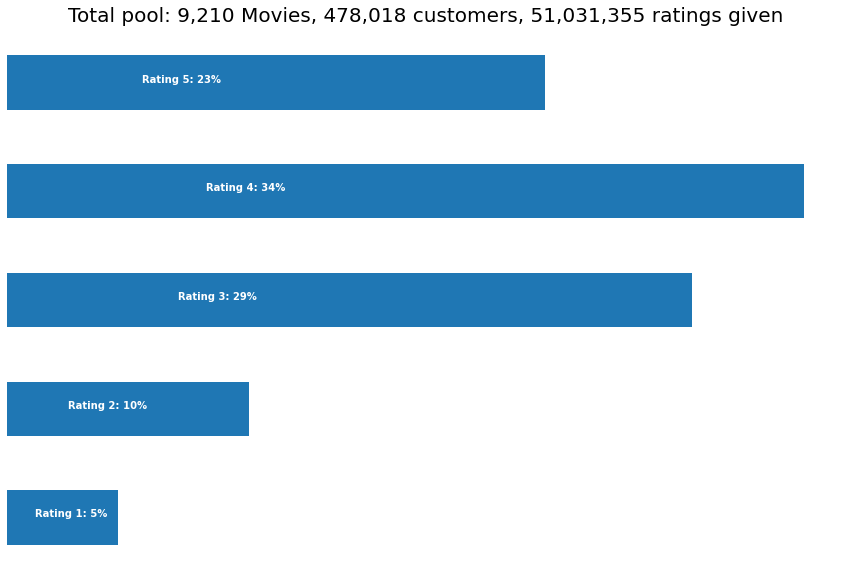

In [24]:
ax = p.plot(kind = 'barh', legend = False, figsize = (15, 10))
plt.title('Total pool: {:,} Movies, {:,} customers, {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=20)
plt.axis('off')

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')

## data cleansing

In [27]:
df.Rating

0           NaN
1           3.0
2           5.0
3           4.0
4           4.0
           ... 
26982297    1.0
26982298    3.0
26982299    3.0
26982300    4.0
26982301    3.0
Name: Rating, Length: 51040565, dtype: float64

In [26]:
# dataframe에 null값 확인
pd.isnull(df.Rating)

0            True
1           False
2           False
3           False
4           False
            ...  
26982297    False
26982298    False
26982299    False
26982300    False
26982301    False
Name: Rating, Length: 51040565, dtype: bool

In [28]:
pd.DataFrame(pd.isnull(df.Rating))

,Rating
0,True
1,False
2,False
3,False
4,False
...,...
26982297,False
26982298,False
26982299,False
26982300,False


In [29]:
df_nan = pd.DataFrame(pd.isnull(df.Rating))

In [31]:
# nan인것만으로 데이터 프레임 만들기
df_nan[df_nan['Rating'] == True]

,Rating
0,True
548,True
694,True
2707,True
2850,True
...,...
26957496,True
26959947,True
26961403,True
26980373,True


In [32]:
df_nan = df_nan[df_nan['Rating'] == True]

In [34]:
# 인덱스 초기화
df_nan = df_nan.reset_index()

In [35]:
df_nan

,index,Rating
0,0,True
1,548,True
2,694,True
3,2707,True
4,2850,True
...,...,...
9205,26957496,True
9206,26959947,True
9207,26961403,True
9208,26980373,True


In [66]:
df_nan['index'][:-1]

0              0
1            548
2            694
3           2707
4           2850
          ...   
9204    26891562
9205    26957496
9206    26959947
9207    26961403
9208    26980373
Name: index, Length: 9209, dtype: int64

In [65]:
cnt = 0
for i, j in zip(df_nan['index'][1:], df_nan['index'][:-1]):
    if cnt == 5:
        break
    print("i ", i)

    print("j", j)
    print("========")
    cnt+=1

i  548
j 0
i  694
j 548
i  2707
j 694
i  2850
j 2707
i  3991
j 2850


In [67]:
print(len(df_nan['index'][1:]))
print(len(df_nan['index'][:-1]))

9209
9209


In [68]:
movie_np = []
movie_id = 1
# np.full((1,10), 2) : 1 부터 10 총 10개를 2로 채운다
for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
    # numpy approach
    temp = np.full((1,i-j-1), movie_id)
    movie_np = np.append(movie_np, temp)
    movie_id += 1

ValueError: ignored

In [41]:
np.full((1, 10), 2)

array([[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]])

In [42]:
movie_id

4499

In [45]:
movie_np = []

In [49]:
movie_np = np.append(movie_np,np.full((1, 10), 2) )

In [51]:
movie_np = np.append(movie_np,np.full((1, 10), 3) )
movie_np

array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.])

In [52]:
len(movie_np)

30

In [53]:
df_nan.iloc[-1, 0]

26980497

In [55]:
df_nan.iloc[-1, 0] -1

26980496

In [54]:
df_nan

,index,Rating
0,0,True
1,548,True
2,694,True
3,2707,True
4,2850,True
...,...,...
9205,26957496,True
9206,26959947,True
9207,26961403,True
9208,26980373,True


In [61]:
np.full((1,len(df) - df_nan.iloc[-1, 0] - 1), movie_id)

array([[1, 1, 1, ..., 1, 1, 1]])

1